In [1]:
#This project requires you to download yfinance, BeautifulSoup, Matplotlib & NLTK packages. 
#Incase you don't have them installed, type the following commands in your python terminal - (python version 3.7).
#pip install yfinance
#pip install beautifulsoup4
#pip install nltk
#pip install matplotlib

## Importing Libraries

In [2]:
#importing libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import nltk
#Uncomment the line below if your system does not have 'vader-lexicon' installed
#nltk.download('vader_lexicon')

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

## Data Processing

#### Includes the following:
1. Choosing Tickers
2. Requesting data from URL
3. Data Processing

In [4]:
#Defining finviz url
finviz_url = 'https://finviz.com/quote.ashx?t='

In [5]:
tickers = ['AMZN','FB', 'GOOG','AAPL','TSLA']

In [6]:
news_tables = {}

In [7]:
#Requesting data 
for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url = url, headers = {'user-agent':'my-app'})
    response = urlopen(req)
    
    #Parsing HTML documents using Beautiful Soup
    html = BeautifulSoup(response,'html')
    
    #Saving the News Table in a dictionary
    news_table = html.find(id = 'news-table')
    news_tables[ticker] = news_table

In [8]:
#Test Run
#fb_data = news_table['FB']
#fb_rows = fb_data.findAll('tr')

In [9]:
#for index, row in enumerate(fb_rows):
    #title = row.a.text()
    #timestamp = row.td.text
    #print(timestamp + ' ' + title)

In [10]:
parsed_data=[]

In [11]:
#Decomposing the dictionary 4 into relevant items - Ticker, Date,Time, News Title
for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        title = row.a.get_text()
        #Splitting date after every space
        date_data = row.td.text.split(' ')
        
        #Check if date_data has two elements (date + time) or just 1 element (time)
        if len(date_data)==1:
            time=date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
        
        #Appending decomposed items into a list
        parsed_data.append([ticker, date, time, title])

In [12]:
#Converting list into dataframe
df = pd.DataFrame(parsed_data,columns=['Ticker', 'Date', 'Time', 'Title'])

In [13]:
df.head()

,Ticker,Date,Time,Title
0,AMZN,Mar-14-21,08:15AM,2 Top Value Stocks to Buy Right Now
1,AMZN,Mar-14-21,07:07AM,Here's How SpaceX Plans to Dominate the Space ...
2,AMZN,Mar-14-21,07:05AM,3 Stocks to Buy and Hold for Decades
3,AMZN,Mar-14-21,06:45AM,These 3 Tech Stocks Are Building the Future
4,AMZN,Mar-14-21,05:15AM,3.14 Ways to Start Investing


## Calculating Sentiment Score of the Text

#### Includes the following
1. Compute compound scores using polarity_scores()
2. Convert String Date to Date Format
3. Compute mean of compound scores & store it new dataframe
4. Processing the above dataframe for easy usage

In [14]:
#Calling Sentiment Intensity Analyzer Function & assigning it to variable 'vader'
vader = SentimentIntensityAnalyzer()

In [15]:
#Function 'f' to calculate polarity scores of News Title
#Interested only in compound Scores
f = lambda title: vader.polarity_scores(title)['compound']
df['Compound'] = df['Title'].apply(f)

In [16]:
df.head()

,Ticker,Date,Time,Title,Compound
0,AMZN,Mar-14-21,08:15AM,2 Top Value Stocks to Buy Right Now,0.4939
1,AMZN,Mar-14-21,07:07AM,Here's How SpaceX Plans to Dominate the Space ...,-0.1280
2,AMZN,Mar-14-21,07:05AM,3 Stocks to Buy and Hold for Decades,0.0000
3,AMZN,Mar-14-21,06:45AM,These 3 Tech Stocks Are Building the Future,0.0000
4,AMZN,Mar-14-21,05:15AM,3.14 Ways to Start Investing,0.0000


In [17]:
#Converting Date column (string) data into Date format
df['Date'] = pd.to_datetime(df.Date).dt.date

In [18]:
#Creating a new dataframe using Groupby function & storing mean of compound scores
mean_df = df.groupby(['Ticker','Date']).mean()
mean_df.head()

Compound
Ticker Date                
AAPL   2021-03-09  0.044606
       2021-03-10  0.005939
       2021-03-11  0.070805
       2021-03-12  0.184770
       2021-03-13  0.053990

In [19]:
#convert the dataframe into unstacked format.
mean_df = mean_df.unstack()

#Transposing the matrix:
#1. Ticker Row is converted to Columns
#2. The xs() function is used to get cross-section from the Series/DataFrame.
#This method takes a key argument to select data at a particular level of a MultiIndex.

mean_df = mean_df.xs('Compound',axis='columns').transpose()
mean_df.head()

Ticker,AAPL,AMZN,FB,GOOG,TSLA
Date,,,,,
2021-03-05,NaN,NaN,0.088057,0.168750,NaN
2021-03-06,NaN,NaN,0.318450,0.208140,NaN
2021-03-07,NaN,NaN,0.399600,-0.048833,NaN
2021-03-08,NaN,NaN,0.103231,0.135650,NaN
2021-03-09,0.044606,0.36755,-0.061148,0.033005,NaN


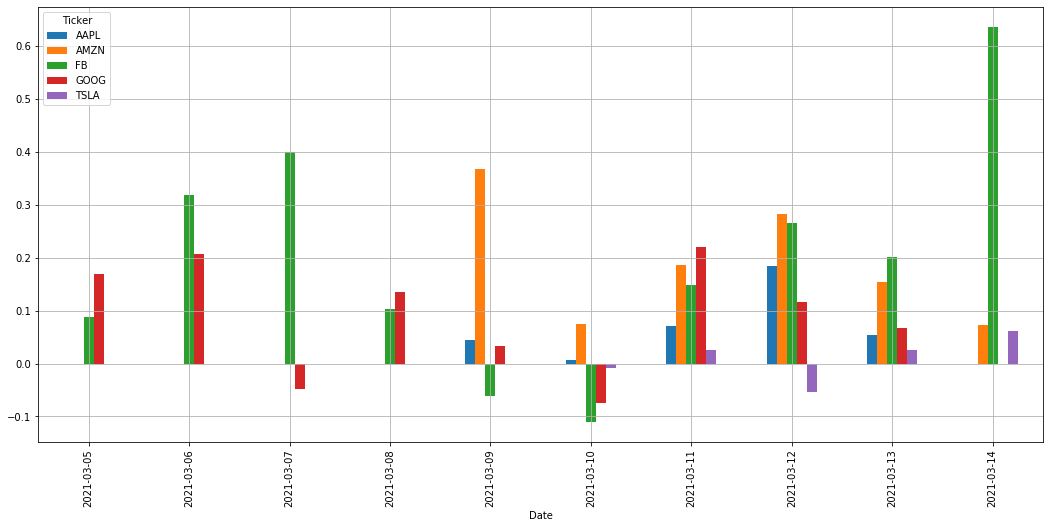

In [20]:
#Plot Compound Scores of each stock into a Bar chart
mean_df.plot(kind='bar',figsize=(18,8),grid=True)
plt.show()

## Download historical data

#### Includes the following:
1. Download Historical Data
2. Calculate Daily Returns 

In [21]:
#Downloading historical data using yfinance. We are interested only in 'Adjusted Closing Price'
df2 = pd.DataFrame()
#Assigning the startdate as the first date in mean_df dataframe
startdate = mean_df.index[0]
#Optional : Assigning the enddate as the last date in mean_df dataframe
enddate = mean_df.index[-1]
for ticker in tickers:
    df2[ticker] = yf.download(ticker,start = startdate, end = enddate)['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [22]:
df2.head()

,AMZN,FB,GOOG,AAPL,TSLA
Date,,,,,
2021-03-04,2977.570068,257.640015,2049.090088,120.129997,621.440002
2021-03-05,3000.459961,264.279999,2108.540039,121.419998,597.950012
2021-03-08,2951.949951,255.309998,2024.170044,116.360001,563.000000
2021-03-09,3062.850098,265.739990,2052.699951,121.089996,673.580017
2021-03-10,3057.639893,264.899994,2055.030029,119.980003,668.059998


In [23]:
df2.tail()

,AMZN,FB,GOOG,AAPL,TSLA
Date,,,,,
2021-03-08,2951.949951,255.309998,2024.170044,116.360001,563.000000
2021-03-09,3062.850098,265.739990,2052.699951,121.089996,673.580017
2021-03-10,3057.639893,264.899994,2055.030029,119.980003,668.059998
2021-03-11,3113.590088,273.880005,2114.770020,121.959999,699.599976
2021-03-12,3089.489990,268.399994,2061.919922,121.029999,693.729980


In [24]:
#Daily Returns
df2_returns = df2.pct_change()
df2_returns.tail()

,AMZN,FB,GOOG,AAPL,TSLA
Date,,,,,
2021-03-08,-0.016168,-0.033941,-0.040013,-0.041674,-0.058450
2021-03-09,0.037568,0.040852,0.014095,0.040650,0.196412
2021-03-10,-0.001701,-0.003161,0.001135,-0.009167,-0.008195
2021-03-11,0.018298,0.033900,0.029070,0.016503,0.047211
2021-03-12,-0.007740,-0.020009,-0.024991,-0.007625,-0.008391


## Data Analysis

#### Includes the following:
1. Understand the correlation between Daily Returns & Sentiment Score
2. Visualize the daily returns correlation

In [25]:
df2_returns.corrwith(mean_df)

AMZN    0.557962
FB     -0.320333
GOOG    0.168203
AAPL   -0.289342
TSLA    0.821090
dtype: float64

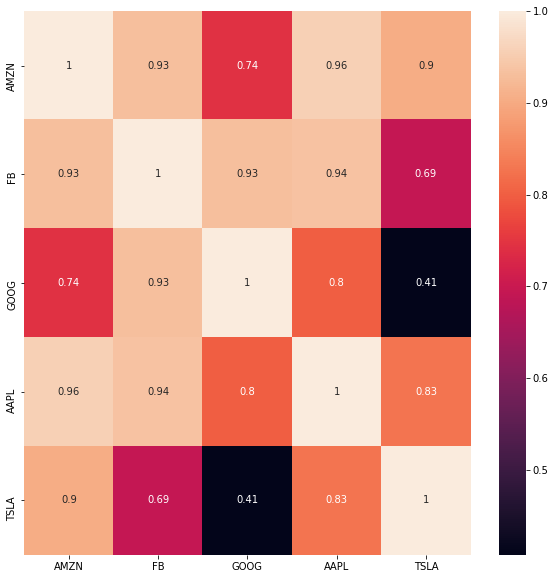

In [26]:
plt.figure(figsize=(10,10))
corr1 = df2_returns.corr()
sns.heatmap(corr1, annot = True)